In [1]:
!pip install -U ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.1 MB/s eta 0:00:00a 0:00:01


In [2]:
import os
import shutil
import cv2
import torch
import yaml
import glob
import random
import math
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.cuda.amp import autocast, GradScaler
from ultralytics import YOLO, RTDETR
from torchvision.ops import box_iou
from sklearn.metrics import confusion_matrix, precision_recall_curve

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# path
input_train_img = '/kaggle/input/dataset/train/images'
input_train_lab = '/kaggle/input/dataset/train/labels'
input_val_img   = '/kaggle/input/dataset/valid/images'
input_val_lab   = '/kaggle/input/dataset/valid/labels'
input_test_img  = '/kaggle/input/dataset/test/images'
input_test_lab  = '/kaggle/input/dataset/test/labels'
video_source    = "/kaggle/input/project-video/video4.mp4"

# working directory
work_dir = '/kaggle/working/data_balanced'
train_dir_img = f'{work_dir}/train/images'
train_dir_lab = f'{work_dir}/train/labels'
val_dir_img   = f'{work_dir}/valid/images'
val_dir_lab   = f'{work_dir}/valid/labels'
output_video_dir = '/kaggle/working/video_results'
benchmark_dir = '/kaggle/working/benchmark'

for d in [train_dir_img, train_dir_lab, val_dir_img, val_dir_lab, output_video_dir, benchmark_dir]:
    if os.path.exists(d): shutil.rmtree(d)
    os.makedirs(d, exist_ok=True)

class_names = ['Gengar', 'Greninja', 'Snorlax', 'bulbasaur', 'charizard', 'charmander', 'eevee', 'pikachu', 'squirtle']
num_classes = len(class_names)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Device: cuda


In [3]:
# data exploration
def count_labels(label_path):
    counts = {i: 0 for i in range(num_classes)}
    for file in glob.glob(os.path.join(label_path, '*.txt')):
        with open(file, 'r') as f:
            for line in f:
                cls = int(line.split()[0])
                if cls in counts:
                    counts[cls] += 1
    return counts


train_counts = count_labels(input_train_lab)
val_counts = count_labels(input_val_lab)
test_counts = count_labels(input_test_lab)


exploration_df = pd.DataFrame({
    'Pokemon': class_names,
    'Train': [train_counts[i] for i in range(num_classes)],
    'Valid': [val_counts[i] for i in range(num_classes)],
    'Test': [test_counts[i] for i in range(num_classes)]
})

exploration_df.loc['Total'] = exploration_df[['Train', 'Valid', 'Test']].sum()
exploration_df.iloc[-1, 0] = 'TOTAL'

print("Distribuzione delle classi nel dataset originale:")
display(exploration_df)

Distribuzione delle classi nel dataset originale:


,Pokemon,Train,Valid,Test
0,Gengar,83.0,47.0,6.0
1,Greninja,84.0,40.0,12.0
2,Snorlax,42.0,12.0,6.0
3,bulbasaur,122.0,34.0,18.0
4,charizard,113.0,34.0,8.0
5,charmander,208.0,56.0,33.0
6,eevee,22.0,11.0,5.0
7,pikachu,280.0,89.0,65.0
8,squirtle,155.0,39.0,31.0
Total,TOTAL,1109.0,362.0,184.0


In [4]:
# data augumentation
def augment_and_balance(src_img, src_lab, dst_img, dst_lab, target_count):
    print(f"Processing {src_img} -> Target: {target_count} per class...")
    
    # input file
    files = [f for f in os.listdir(src_img) if f.endswith(('.jpg','.png','.jpeg'))]
    class_map = {i: [] for i in range(num_classes)}
    
    for f in files:
        shutil.copy(os.path.join(src_img, f), os.path.join(dst_img, f))
        txt_name = f.rsplit('.', 1)[0] + '.txt'
        src_txt = os.path.join(src_lab, txt_name)
        dst_txt = os.path.join(dst_lab, txt_name)
        
        if os.path.exists(src_txt):
            shutil.copy(src_txt, dst_txt)
            with open(src_txt, 'r') as file:
                for line in file:
                    c = int(line.split()[0])
                    if c in class_map: class_map[c].append((os.path.join(dst_img, f), dst_txt))
        else:
            open(dst_txt, 'w').close() # Crea file vuoto se manca

    #  augumentation parameters
    tf = A.Compose([
        A.HorizontalFlip(p=0.5), A.RandomBrightnessContrast(p=0.5), 
        A.Rotate(limit=15, p=0.5), A.GaussianBlur(p=0.2)
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

    # imgages generation
    for cls, items in class_map.items():
        if not items: continue
        needed = target_count - len(items)
        if needed <= 0: continue
        
        print(f"  Augmenting Class {cls}: +{needed}")
        for i in range(needed):
            img_p, txt_p = random.choice(items)
            image = cv2.cvtColor(cv2.imread(img_p), cv2.COLOR_BGR2RGB)
            
            bboxes, labels = [], []
            with open(txt_p, 'r') as f:
                for line in f:
                    p = list(map(float, line.split()))
                    bboxes.append(p[1:]) # x, y, w, h
                    labels.append(int(p[0]))
            
            try:
                aug = tf(image=image, bboxes=bboxes, class_labels=labels)
                new_name = f"aug_{cls}_{i}_{os.path.basename(img_p)}"
                cv2.imwrite(os.path.join(dst_img, new_name), cv2.cvtColor(aug['image'], cv2.COLOR_RGB2BGR))
                
                with open(os.path.join(dst_lab, new_name.rsplit('.', 1)[0]+'.txt'), 'w') as f:
                    for c, b in zip(aug['class_labels'], aug['bboxes']):
                        b = [max(0.0, min(1.0, x)) for x in b] # Clamp 0-1
                        f.write(f"{c} {b[0]:.6f} {b[1]:.6f} {b[2]:.6f} {b[3]:.6f}\n")
            except: pass

# augmented dataset
augment_and_balance(input_train_img, input_train_lab, train_dir_img, train_dir_lab, 280)
augment_and_balance(input_val_img, input_val_lab, val_dir_img, val_dir_lab, 90)

# yamal unpdate
yaml_data = {'train': train_dir_img, 'val': val_dir_img, 'test': input_test_img, 'nc': num_classes, 'names': class_names}
with open('data.yaml', 'w') as f: yaml.dump(yaml_data, f)

Processing /kaggle/input/dataset/train/images -> Target: 280 per class...
  Augmenting Class 0: +197
  Augmenting Class 1: +196
  Augmenting Class 2: +238
  Augmenting Class 3: +158
  Augmenting Class 4: +167
  Augmenting Class 5: +72
  Augmenting Class 6: +258
  Augmenting Class 8: +125
Processing /kaggle/input/dataset/valid/images -> Target: 90 per class...
  Augmenting Class 0: +43
  Augmenting Class 1: +50
  Augmenting Class 2: +78
  Augmenting Class 3: +56
  Augmenting Class 4: +56
  Augmenting Class 5: +34
  Augmenting Class 6: +79
  Augmenting Class 7: +1
  Augmenting Class 8: +51


In [5]:
# yolo -> pascal cooredinate trasformation
class FRCNNDataset(Dataset):
    def __init__(self, img_dir, lab_dir):
        self.imgs = [f for f in os.listdir(img_dir) if f.endswith(('.jpg','.png','.jpeg'))]
        self.img_dir = img_dir
        self.lab_dir = lab_dir
        self.tf = T.Compose([T.ToTensor(), T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def __getitem__(self, idx):
        name = self.imgs[idx]
        img_path = os.path.join(self.img_dir, name)
        img = cv2.imread(img_path)

        # if images corropted
        if img is None: 
            return self._empty_target()
            
        img = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (640, 640))
        lab_path = os.path.join(self.lab_dir, name.rsplit('.', 1)[0] + '.txt')
        
        boxes, labels = [], []
        if os.path.exists(lab_path):
            with open(lab_path) as f:
                for line in f:
                    # first 5
                    parts = list(map(float, line.strip().split()))
                    if len(parts) >= 5:
                        c, cx, cy, w, h = int(parts[0]), parts[1], parts[2], parts[3], parts[4]
                        
                        # formula yolo -> pascal
                        x1 = (cx - w/2) * 640
                        y1 = (cy - h/2) * 640
                        x2 = (cx + w/2) * 640
                        y2 = (cy + h/2) * 640
                        
                        # range for not give errors in traning
                        x1, y1 = max(0, x1), max(0, y1)
                        x2, y2 = min(640, x2), min(640, y2)
                        
                        if (x2-x1) > 1 and (y2-y1) > 1:
                            boxes.append([x1, y1, x2, y2])
                            labels.append(c + 1) # +1 for backgound

        if not boxes: 
            return self._empty_target(img)
            
        return self.tf(img), {'boxes': torch.tensor(boxes, dtype=torch.float32), 'labels': torch.tensor(labels, dtype=torch.int64)}

    def _empty_target(self, img=None):
        if img is None:
            tens = torch.zeros((3, 640, 640), dtype=torch.float32)
        else:
            tens = self.tf(img)
        return tens, {'boxes': torch.zeros((0,4), dtype=torch.float32), 'labels': torch.zeros((0,), dtype=torch.int64)}

    def __len__(self): return len(self.imgs)
        
def collate_fn(b): return tuple(zip(*b))

In [6]:
frcnn = fasterrcnn_resnet50_fpn(weights='DEFAULT', trainable_backbone_layers=5)
frcnn.roi_heads.box_predictor = FastRCNNPredictor(frcnn.roi_heads.box_predictor.cls_score.in_features, num_classes + 1)
frcnn.to(device)

opt = torch.optim.SGD([p for p in frcnn.parameters() if p.requires_grad], lr=0.002, momentum=0.9, weight_decay=0.0005)
scaler = GradScaler()
loader = DataLoader(FRCNNDataset(train_dir_img, train_dir_lab), batch_size=8, shuffle=True, collate_fn=collate_fn, num_workers=2)

frcnn_losses = []
frcnn.train()

for ep in range(25):
    loss_sum, valid = 0, 0
    for imgs, t in loader:
        try:
            imgs = [i.to(device) for i in imgs]
            t = [{k: v.to(device) for k, v in x.items()} for x in t]
            
            # Salta batch vuoti se capitano
            if len(t) == 0: continue

            opt.zero_grad()
            with autocast():
                loss_dict = frcnn(imgs, t)
                loss = sum(loss_dict.values())
            
            if math.isfinite(loss.item()):
                scaler.scale(loss).backward()
                scaler.step(opt)
                scaler.update()
                loss_sum += loss.item()
                valid += 1
        except Exception as e:
            continue

    avg = loss_sum/valid if valid else 0
    print(f"FRCNN Epoch {ep+1}: {avg:.4f}")
    frcnn_losses.append(avg)

torch.save(frcnn.state_dict(), 'frcnn.pth')
print("Faster R-CNN Training Complete.")

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:02<00:00, 64.3MB/s] 
/tmp/ipykernel_55/2960843527.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_55/2960843527.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


FRCNN Epoch 1: 0.3843
FRCNN Epoch 2: 0.2141
FRCNN Epoch 3: 0.1791
FRCNN Epoch 4: 0.1574
FRCNN Epoch 5: 0.1432
FRCNN Epoch 6: 0.1360
FRCNN Epoch 7: 0.1250
FRCNN Epoch 8: 0.1209
FRCNN Epoch 9: 0.1107
FRCNN Epoch 10: 0.1069
FRCNN Epoch 11: 0.1028
FRCNN Epoch 12: 0.0965
FRCNN Epoch 13: 0.0944
FRCNN Epoch 14: 0.0891
FRCNN Epoch 15: 0.0860
FRCNN Epoch 16: 0.0805
FRCNN Epoch 17: 0.0799
FRCNN Epoch 18: 0.0773
FRCNN Epoch 19: 0.0744
FRCNN Epoch 20: 0.0704
FRCNN Epoch 21: 0.0719
FRCNN Epoch 22: 0.0664
FRCNN Epoch 23: 0.0641
FRCNN Epoch 24: 0.0617
FRCNN Epoch 25: 0.0609
Faster R-CNN Training Complete.


In [8]:
#yolo traning
if torch.cuda.device_count() > 1:
    device = torch.device('cuda')
    device_ids = [0, 1]
yolo = YOLO('yolo11s.pt')
_ = yolo.train(data='data.yaml', epochs=30, imgsz=640, batch=32, project='benchmark', name='yolo', 
               freeze=10, verbose=False, device=device_ids, deterministic=False)

Ultralytics 8.4.6 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
                                                     CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=False, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=yolo2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, o

In [9]:
#traning rtdert
rtdetr = RTDETR('rtdetr-l.pt')
_ = rtdetr.train(data='data.yaml', epochs=30, imgsz=640, batch=16, project='benchmark', name='rtdetr', 
                 freeze=10, verbose=False, device=device_ids, deterministic=False)

Ultralytics 8.4.6 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
                                                     CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=False, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=rtdetr-l.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=rtdetr, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto,

In [ ]:
# test yolo -> pascal con la funzione FRCNNDataset
test_dataset = FRCNNDataset(input_test_img, input_test_lab)
dl_test = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn, num_workers=2)

frcnn_eval = frcnn 
class_names_plus_bg = ['Background'] + class_names  
frcnn_eval.eval()
conf_threshold = 0.5


# all metrics
res_list = [] 
pr_curves = {} 
cm_true = []  
cm_pred = []
all_scores = [] 
all_matches = []
all_ious = []

total_gt_objects = 0
t0 = time.time()

# for confusion matrix
with torch.no_grad():
    for imgs, targets in dl_test:
        imgs = [img.to(device) for img in imgs]
        outputs = frcnn_eval(imgs)
        
        for i, out in enumerate(outputs):

            p_boxes = out['boxes'].cpu()
            p_scores = out['scores'].cpu()
            p_labels = out['labels'].cpu()
            
            gt_boxes = targets[i]['boxes'].cpu()
            gt_labels = targets[i]['labels'].cpu()
            total_gt_objects += len(gt_labels)
            
            # no predictions
            if len(p_boxes) == 0:
                for lbl in gt_labels:
                    cm_true.append(lbl.item())
                    cm_pred.append(0)
                continue
            
            # ground thruth 
            if len(gt_boxes) > 0:
                iou_matrix = box_iou(p_boxes, gt_boxes)
                matched_gt_indices = set()
                
                sorted_indices = torch.argsort(p_scores, descending=True)
                
                for idx in sorted_indices:
                    score = p_scores[idx].item()
                    label = p_labels[idx].item()
                    
                    # low confidence
                    if score < conf_threshold:
                        continue


                    all_scores.append(score)
                    
                    if iou_matrix.size(1) > 0:
                        max_iou, max_gt_idx = iou_matrix[idx].max(0)
                        
                        if max_iou > 0.5 and max_gt_idx.item() not in matched_gt_indices:
                            gt_lbl = gt_labels[max_gt_idx].item()
                            
                            cm_pred.append(label)
                            cm_true.append(gt_lbl)
                            
                            if label == gt_lbl:
                                all_matches.append(1) 
                                all_ious.append(max_iou.item())
                            else:
                                all_matches.append(0) 
                            
                            matched_gt_indices.add(max_gt_idx.item())
                        else:

                            cm_pred.append(label)
                            cm_true.append(0)
                            all_matches.append(0)
                    else:

                        cm_pred.append(label)
                        cm_true.append(0)
                        all_matches.append(0)
                

                for k in range(len(gt_labels)):
                    if k not in matched_gt_indices:
                        cm_true.append(gt_labels[k].item())
                        cm_pred.append(0)

            else:
                for label, score in zip(p_labels, p_scores):
                    if score.item() < conf_threshold:
                        continue

                    cm_pred.append(label.item())
                    cm_true.append(0)
                    all_scores.append(score.item())
                    all_matches.append(0)

# metrics calculation
inference_time = (time.time() - t0) / len(dl_test.dataset) * 1000
tp = sum(all_matches)
fp = len(all_matches) - tp
fn = total_gt_objects - tp

precision_calc = tp / (tp + fp + 1e-6)
recall_calc = tp / (tp + fn + 1e-6)
f1_calc = 2 * (precision_calc * recall_calc) / (precision_calc + recall_calc + 1e-6)

# pr curve
prec_arr, rec_arr, _ = precision_recall_curve(all_matches, all_scores)
pr_curves['Faster R-CNN'] = (rec_arr, prec_arr)

# list
res_list.append({
    'Model': 'Faster R-CNN', 
    'IoU': np.mean(all_ious) if all_ious else 0.0,
    'Precision': precision_calc, 
    'Recall': recall_calc,
    'F1-Score': f1_calc, 
    'Inference (ms)': inference_time
})

print(f"Valutazione completata con soglia {conf_threshold}")
print(f"Precision: {precision_calc:.4f}, Recall: {recall_calc:.4f}, F1: {f1_calc:.4f}")

In [12]:
# metrics for yolo and rt-dert
for m_name, model in [('YOLOv11s', yolo), ('RT-DETR', rtdetr)]:
    print(f"Evaluating {m_name}...")
    m_res = model.val(split='test', verbose=False, device=device)
    
    p_curve = np.array(m_res.box.p_curve)
    r_curve = np.array(m_res.box.r_curve)
    if p_curve.ndim > 1: p_curve = p_curve.mean(axis=0)
    if r_curve.ndim > 1: r_curve = r_curve.mean(axis=0)
    pr_curves[m_name] = (r_curve, p_curve)
    
    res_list.append({
        'Model': m_name, 
        'IoU': m_res.box.map,
        'Precision': m_res.box.mp, 
        'Recall': m_res.box.mr, 
        'F1-Score': 2 * (m_res.box.mp * m_res.box.mr) / (m_res.box.mp + m_res.box.mr + 1e-6),
        'Inference (ms)': m_res.speed['inference']
    })

Evaluating YOLOv11s...
YOLO11s summary (fused): 101 layers, 9,416,283 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 140.0±118.8 MB/s, size: 74.0 KB)
val: Scanning /kaggle/input/dataset/test/labels... 167 images, 14 backgrounds, 2 corrupt: 100% ━━━━━━━━━━━━ 167/167 797.9it/s 0.2s0.0s
val: /kaggle/input/dataset/test/images/Charmander_208_png.rf.68b6ed73b74eb873e09d7f0294216d2b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0211]
val: /kaggle/input/dataset/test/images/Greninja_190_png.rf.f3e885e4f357df60e520bbda4fe990ed.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0268]
WARNING ⚠️ val: Cache directory /kaggle/input/dataset/test is not writable, cache not saved.
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 64, len(boxes) = 182. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a de

In [20]:
#df
df_comparison = pd.DataFrame(res_list).round(4)
df_comparison

,Model,IoU,Precision,Recall,F1-Score,Inference (ms)
0,Faster R-CNN,0.7976,0.1836,0.7898,0.2980,88.2908
1,YOLOv11s,0.7871,0.9437,0.8499,0.8943,10.9905
2,RT-DETR,0.7387,0.8248,0.7905,0.8073,34.2799


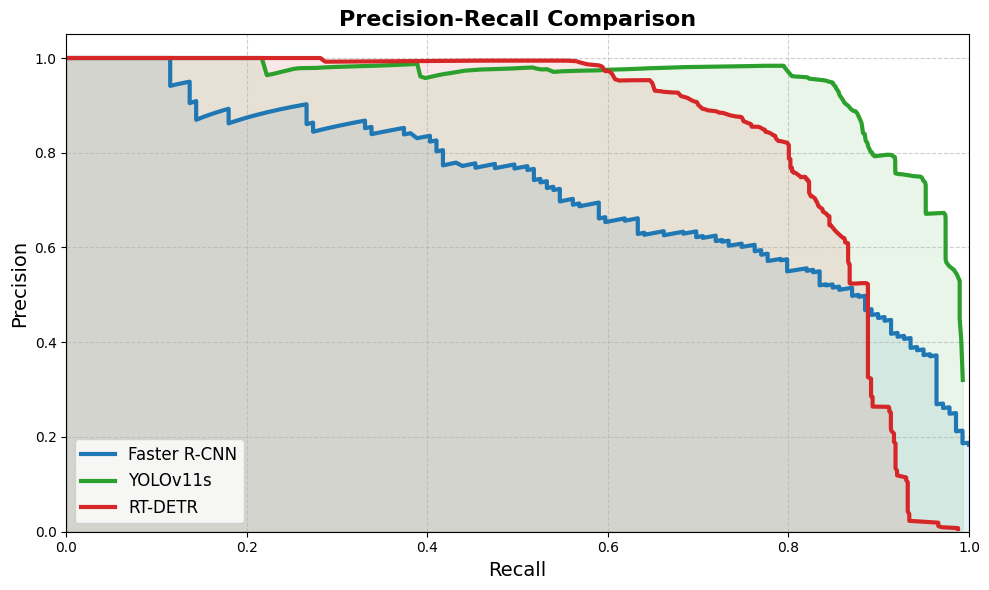

In [14]:
#plot
plt.figure(figsize=(10, 6), facecolor='white')
colors = {'Faster R-CNN': '#1f77b4', 'YOLOv11s': '#2ca02c', 'RT-DETR': '#d62728'}

for name, (rec, prec) in pr_curves.items():
    plt.plot(rec, prec, label=name, color=colors[name], linewidth=3)
    plt.fill_between(rec, prec, color=colors[name], alpha=0.1)

plt.title('Precision-Recall Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower left', fontsize=12)
plt.tight_layout()
plt.show()


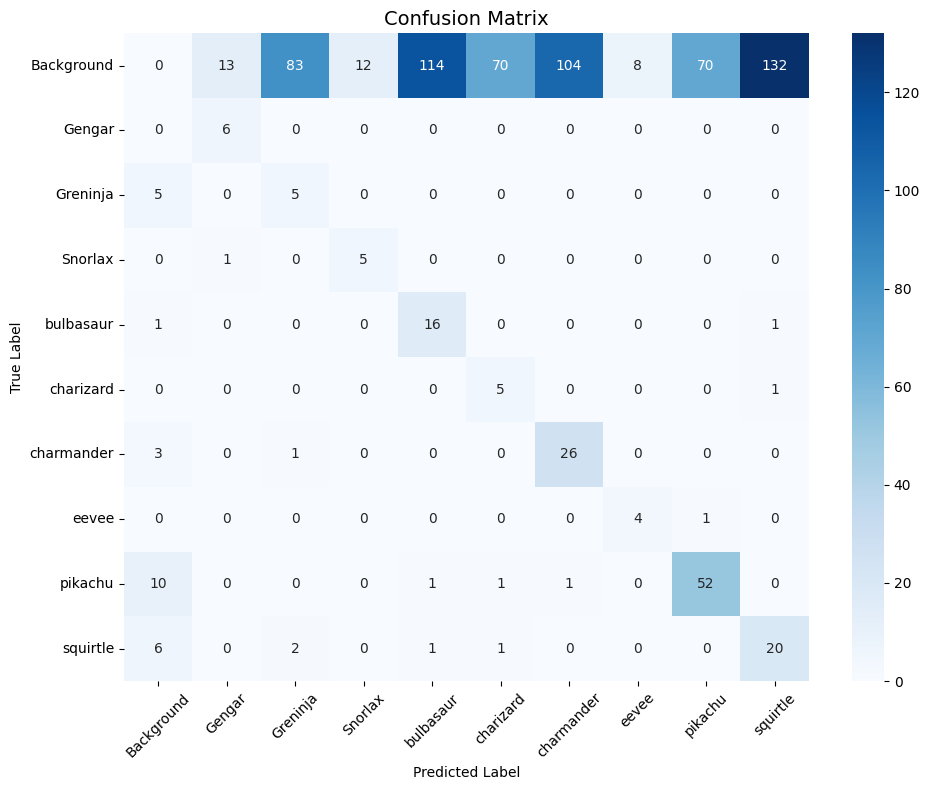

In [15]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(cm_true, cm_pred, labels=range(len(class_names_plus_bg)))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names_plus_bg, yticklabels=class_names_plus_bg)
plt.title('Confusion Matrix', fontsize=14)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

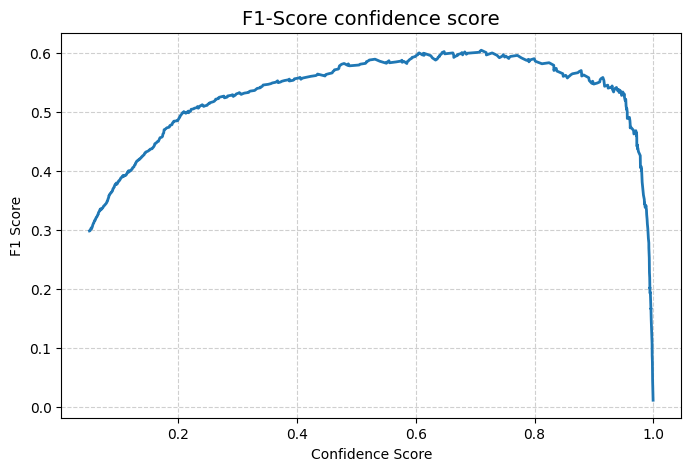

In [16]:
scores_np = np.array(all_scores)
matches_np = np.array(all_matches)
sort_inds = np.argsort(-scores_np) 
scores_sorted = scores_np[sort_inds]
matches_sorted = matches_np[sort_inds]

tp_cumsum = np.cumsum(matches_sorted)
fp_cumsum = np.cumsum(1 - matches_sorted)
precision_c = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)
recall_c = tp_cumsum / (total_gt_objects + 1e-6)
f1_curve = 2 * (precision_c * recall_c) / (precision_c + recall_c + 1e-6)


plt.figure(figsize=(8, 5))
plt.plot(scores_sorted, f1_curve, linewidth=2, color='#1f77b4')
plt.title('F1-Score confidence score', fontsize=14)
plt.xlabel('Confidence Score')
plt.ylabel('F1 Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

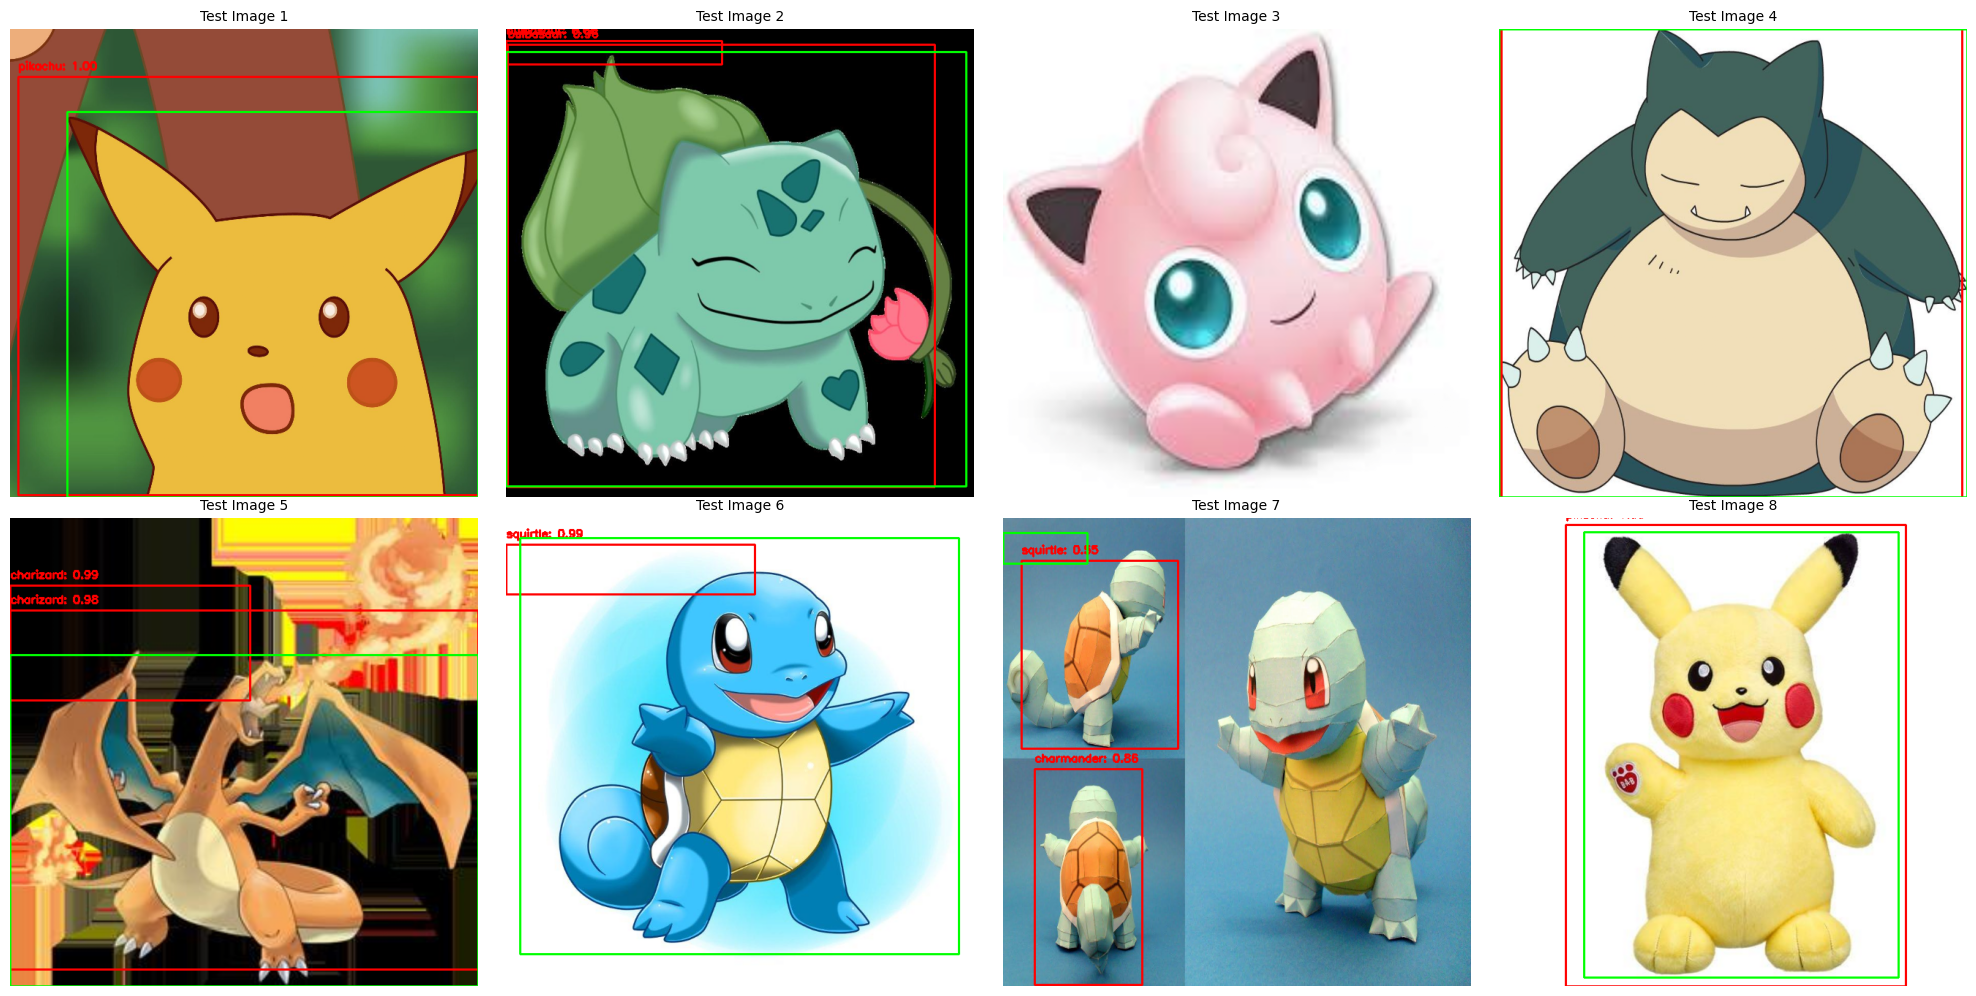

In [17]:
imgs, targets = next(iter(dl_test))
imgs_gpu = [img.to(device) for img in imgs]
frcnn_eval.eval()
outputs = frcnn_eval(imgs_gpu)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i in range(min(8, len(imgs))):
    img_tensor = imgs[i].permute(1, 2, 0).cpu().numpy()
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = std * img_tensor + mean
    img_np = np.clip(img_np, 0, 1)
    
    img_np = np.ascontiguousarray(img_np, dtype=np.float32)
    
    boxes = outputs[i]['boxes'].detach().cpu().numpy()
    scores = outputs[i]['scores'].detach().cpu().numpy()
    labels = outputs[i]['labels'].detach().cpu().numpy()
    
    mask = scores > 0.5
    boxes = boxes[mask]
    labels = labels[mask]
    scores = scores[mask]
    
    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = box.astype(int)
        cv2.rectangle(img_np, (x1, y1), (x2, y2), (1.0, 0.0, 0.0), 2)
        txt = f"{class_names_plus_bg[label]}: {score:.2f}"
        cv2.putText(img_np, txt, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (1.0, 0.0, 0.0), 2)
        
    gt_boxes = targets[i]['boxes'].numpy()
    for box in gt_boxes:
        x1, y1, x2, y2 = box.astype(int)
        cv2.rectangle(img_np, (x1, y1), (x2, y2), (0.0, 1.0, 0.0), 2)
    
    axes[i].imshow(img_np)
    axes[i].set_title(f"Test Image {i+1}", fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [18]:
#yolo
_ = yolo.track(source=video_source, save=True, project=output_video_dir, name='yolo', conf=0.5, verbose=False, device=device_ids[0])
# rt-dert
_ = rtdetr.track(source=video_source, save=True, project=output_video_dir, name='rtdetr', conf=0.5, verbose=False, device=device_ids[0])

#faster r-cnn
cap = cv2.VideoCapture(video_source)
w, h, fps = int(cap.get(3)), int(cap.get(4)), int(cap.get(5))
out = cv2.VideoWriter(f"{output_video_dir}/frcnn.mp4", cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))

tf_inf = T.Compose([T.ToTensor(), T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
while cap.isOpened():
    ret, frame = cap.read()
    if not ret: break
    tens = tf_inf(cv2.cvtColor(cv2.resize(frame, (640, 640)), cv2.COLOR_BGR2RGB)).to(device).unsqueeze(0)
    with torch.no_grad(): preds = frcnn_eval(tens)[0]
    
    sx, sy = w/640, h/640
    for i, s in enumerate(preds['scores']):
        if s > 0.5:
            b = preds['boxes'][i].cpu().numpy()
            x1, y1, x2, y2 = int(b[0]*sx), int(b[1]*sy), int(b[2]*sx), int(b[3]*sy)
            lbl = class_names[int(preds['labels'][i])-1]
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0,255,0), 2)
            cv2.putText(frame, f"{lbl} {s:.2f}", (x1, y1-5), 0, 0.6, (0,255,0), 2)
    out.write(frame)
cap.release(); out.release()
print("Done.")

requirements: Ultralytics requirement ['lap>=0.5.12'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 2 packages in 253ms
Prepared 1 package in 76ms
Installed 1 package in 2ms
 + lap==0.5.12

requirements: AutoUpdate success ✅ 0.9s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect

WARNING ⚠️ 
Inference results will accumulate in RAM unless `stream=True` is passed, which can cause out-of-memory errors for large
sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

WARNING ⚠️ not enough matching points
WARNING ⚠️ not enough matching points
WARNING ⚠️ not enough matc